# Boosting Homework 
***
**Name**: Ahmed Al Hasani 
***

This assignment is due on Moodle by **5pm on Friday April 13th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***



In this homework you'll implement the AdaBoost classification framework to do handwritten digit recognition. Your implementation should be based on the description of AdaBoost given in the lecture slides.

<br>

![digits](mnist.png "mnist data")


<br>

Here are the rules: 

- Do **NOT** use sklearn's implementation of Adaboost.  You may however use sklearn's implementation of decisions trees. 
- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [130]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone 
import matplotlib.pylab as plt
import math
%matplotlib inline 

### [5 points] Problem 1
***

Since we'll be working with binary classifiers, we'll look at the subset of the MNIST data pertaining to handwritten three's and eights. Note that we'll also be using a lower-res version of the MNIST data used in the KNN homework. The class below will load, parse, and store the subset of the. Load the data and then report: 

- The number of examples in the training set 
- The number of examples in the validation set 
- The number of pixels in each image. 

In [131]:
class ThreesAndEights:
    """
    Class to store MNIST data
    """

    def __init__(self, location):

        import pickle, gzip

        # Load the dataset
        f = gzip.open(location, 'rb')

        # Split the data set 
        X_train, y_train, X_valid, y_valid = pickle.load(f)
        
        # Extract only 3's and 8's for training set 
        self.X_train = X_train[np.logical_or( y_train==3, y_train == 8), :]
        self.y_train = y_train[np.logical_or( y_train==3, y_train == 8)]
        self.y_train = np.array([1 if y == 8 else -1 for y in self.y_train])
        
        # Shuffle the training data 
        shuff = np.arange(self.X_train.shape[0])
        np.random.shuffle(shuff)
        self.X_train = self.X_train[shuff,:]
        self.y_train = self.y_train[shuff]

        # Extract only 3's and 8's for validation set 
        self.X_valid = X_valid[np.logical_or( y_valid==3, y_valid == 8), :]
        self.y_valid = y_valid[np.logical_or( y_valid==3, y_valid == 8)]
        self.y_valid = np.array([1 if y == 8 else -1 for y in self.y_valid])
        print("Answers to Problem 1")
        print("Number of Training Data: ", end="")
        print(len(self.X_train))
        print("Number of Test/Validation Data: ", end="")
        print(len(self.X_valid))
        print("Number of Pixels: ", end="")
        print(X_train[0].shape[0])
        print("--------------------------")
        f.close()

In [132]:
data = ThreesAndEights("../data/mnist21x21_3789.pklz")

Answers to Problem 1
Number of Training Data: 2000
Number of Test/Validation Data: 500
Number of Pixels: 441
--------------------------


From the code above, the number of training data is 2000, while the number of test data is 500 only.
Each image has a total number of pixels of 441, which means it is a 21 by 21 image. 

### [20 points] Problem 2: Implementing AdaBoost  
***

We've given you a skeleton of the class `AdaBoost` below which will train a classifier based on boosted shallow decision trees as implemented by sklearn. Take a look at the class skeleton first so that you understand the underlying organization and data structures that we'll be using.  

In [133]:
class AdaBoost:
    def __init__(self, n_learners=20, base=DecisionTreeClassifier(max_depth=1), random_state=1234):
        """
        Create a new adaboost classifier.
        
        Args:
            N (int, optional): Number of weak learners in classifier.
            base (BaseEstimator, optional): Your general weak learner 
            random_state (int, optional): set random generator.  needed for unit testing. 

        Attributes:
            base (estimator): Your general weak learner 
            n_learners (int): Number of weak learners in classifier.
            alpha (ndarray): Coefficients on weak learners. 
            learners (list): List of weak learner instances. 
        """
        
        np.random.seed(random_state)
        
        self.n_learners = n_learners 
        self.base = base
        self.alpha = np.zeros(self.n_learners)
        self.learners = []
        
    def fit(self, X_train, y_train):
        """
        Train AdaBoost classifier on data. Sets alphas and learners. 
        
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        """
        #initialize w's 
        w = np.ones(len(y_train))
        
        #iterate through the learners individually
        for i in range(self.n_learners):    
            #Yields a new estimator with the same parameters that has not been fit on any data
            h = clone(self.base)
            
            #Build a decision tree classifier from the training set
            h.fit(X_train, y_train, sample_weight=w)
            
            #compute y test from H(xi)
            y_test = h.predict(X_train) #same as h_k(x_i)

            #compute error
            correct = 0.0
            total = 0.0
            for j in range(len(y_train)):
                if y_train[j] != y_test[j]:
                    correct += w[j]
                total += w[j]
            err = correct / total
            
            #compute alpha
            self.alpha[i] = 0.5* math.log((1-err)/err)
            
            #change w's
            for z in range(len(w)):
                w[z] = w[z] * math.exp(-self.alpha[i] * y_train[z] * y_test[z])
            
            #normalize w
            w = w/np.linalg.norm(w)
            
            #append h to learners
            self.learners.append(h)
        
    def predict(self, X):
        """
        Adaboost prediction for new data X.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            
        Returns: 
            yhat (ndarray): [n_samples] ndarray of predicted labels {-1,1}
        """
        
        #create a prediction np list with size equal to X's row 
        prediction = np.zeros(X.shape[0])
       
        #summation term
        result = 0
        
        #iterate through the learners
        for i in range(len(self.learners)):
            #sum through all the alphas for all the learners
            result += self.alpha[i] *self.learners[i].predict(X) #H(x) = sign(summation(alpha*h_k(x)))
        
        # -1 for <0 and +1 for >0
        prediction = np.sign(result)
        
        return prediction
        
    def score(self, X, y):
        """
        Computes prediction accuracy of classifier.  
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            Prediction accuracy (between 0.0 and 1.0).
        """
        
        result = self.predict(X)
        
        total = 0.0
        correct = 0.0
        
        for i in range(len(result)) :
            total += 1.0
            if result[i] == y[i] :
                correct += 1.0
        
        return correct / total
        
    
    def staged_score(self, X, y):
        """
        Computes the ensemble score after each iteration of boosting 
        for monitoring purposes, such as to determine the score on a 
        test set after each boost.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            scores (ndarary): [n_learners] ndarray of scores 
        """

        stage_score = np.zeros(self.n_learners)
        predictions = self.predict(X)
        H_X = 0
        
        for i in range(len(self.learners)) :
            #compute H(x)
            H_X += self.alpha[i] * self.learners[i].predict(X) #H(x) = sign(summation(alpha*h_k(x)))
            #print(H_X)
            predictions = np.sign(H_X)
            
            #compute error and accuracy
            correct = 0.0
            total = 0.0
            for j in range(len(predictions)) :
                total += 1.0
                if y[j] == predictions[j] :
                    correct += 1.0
            
            #adjust staged score 
            stage_score[i] = correct / total
        
        return stage_score
    
    def staged_margin(self, x, y):
        """
        Computes the staged margin after each iteration of boosting 
        for a single training example x and true label y
        
        Args:
            x (ndarray): [n_features] ndarray of data 
            y (integer): an integer {-1,1} representing the true label of x 
            
        Returns: 
            margins (ndarary): [n_learners] ndarray of margins 
        """
        margins = np.zeros(self.n_learners)
        
        #compute alpha_k
        normalized_alphas = self.alpha/sum(self.alpha)  
        
        #print("Normalized Alpha: " + str(normalized_alphas))
        #print("Sum Alpha: " + str(sum(self.alpha)))

        for i in range(self.n_learners):            
            #call predict for each learner 
            prediction = self.learners[i].predict([x])[0]
            
            #print("Individual Margins: ", end="")
            #print(normalized_alphas[i]*prediction*y)
            '''
            Note: margin is a summation of alphas. The measure of correctness will adjust the margin
            accordingly. 
            '''
            
            #if correct then +1, otherwise, -1
            measure_of_correctness = prediction*y
            #if its the first learner, there is no previous margin
            if i ==0:
                margins[i] = normalized_alphas[i]*measure_of_correctness
            #otherwise, previous margin exists
            else:
                margins[i] = margins[i-1]+normalized_alphas[i]*measure_of_correctness  
            
        return margins
        
        
        

Recall that the model we attempt to learn in AdaBoost is given by 

$$
H({\bf x}) = \textrm{sign}\left[\displaystyle\sum_{k=1}^K\alpha_k h_k({\bf x}) \right]
$$

where $h_k({\bf x})$ is the $k^\textrm{th}$ weak learner and $\alpha_k$ is it's associated ensemble coefficient.  

**Part A**: Implement the `fit` method to learn the sequence of weak learners $\left\{h_k({\bf x})\right\}_{k=1}^K$ and corresponding coefficients $\left\{ \alpha_k\right\}_{k=1}^K$. Note that you may use sklearn's implementation of DecisionTreeClassifier as your weak learner which allows you to pass as an optional parameter the weights associated with each training example.  An example of instantiating and training a single learner is given in the comments of the `fit` method.  

When you think you're done, run the following unit tests which corresponds to the AdaBoost example given in the lecture slides. 


In [134]:
%run -i tests.py "part A"

test_alphas (__main__.TestBoost) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


**Part B**: After your `fit` method is working properly, implement the `predict` method to make predictions for unseen examples stored in a data matrix ${\bf X}$.  

**Note**: Remember that AdaBoost assumes that your predictions are of the form $y \in \{-1, 1\}$. 

When you think you're done, run the following unit tests which corresponds to the AdaBoost example given in the lecture slides. 

In [135]:
%run -i tests.py "part B"

test_prediction (__main__.TestBoost) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


**Part C**: Next, implement the `score` method which takes in a matrix of examples ${\bf X}$ and their associated true labels ${\bf y}$, makes predictions, and returns the classification accuracy.   

When you think you're done, run the following unit tests. 

In [136]:
%run -i tests.py "part C"

test_score (__main__.TestBoost) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


**Part D**: Finally, implement the `staged_score` method to return an array of prediction accuracies after each iteration of the AdaBoost algorithm.  That is, the staged score array ${\bf s}$ is defined such that ${\bf s}_\ell$ is the prediction accuracy using only the first $\ell$ weak learners.  This function is primarily used as a diagnostic tool for analyzing the performance of your classifier during the training process.  

**Note**: This method can be implemented in a very efficient or very **in**efficient matter.  Be sure to think about this a bit before diving in. 


When you think you're done, run the following unit tests. 

In [137]:
%run -i tests.py "part D"

test_staged_score (__main__.TestBoost) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


### [10 points] Problem 3: AdaBoost for Handwritten Digit Recognition 
***

Use your AdaBoost code with Sklearn's DecisionTreeClassifier as the base learner to distinguish $3$'s from $8$'s. 
Run $n=500$ boosting iterations with trees of depths 1, 2, and 3 (go deeper if you like) as the weak learner. For each weak learner, plot the training and validation error per boosting iteration (on the same set of axes). Compare and contrast the different weak learners. Which works the best? Do you see signs of overfitting? Do any of classifiers achieve nearly 100% accuracy on the training data? What happens to the accuracy on the validation data on further iterations?

In [138]:
booster1 = AdaBoost(n_learners = 500, base=DecisionTreeClassifier(max_depth=1), random_state=1234)
booster1.fit(data.X_train, data.y_train)
booster2 = AdaBoost(n_learners = 500, base=DecisionTreeClassifier(max_depth=2), random_state=1234)
booster2.fit(data.X_train, data.y_train)
booster3 = AdaBoost(n_learners = 500, base=DecisionTreeClassifier(max_depth=3), random_state=1234)
booster3.fit(data.X_train, data.y_train)

In [139]:
train_stage_score1 = booster1.staged_score(data.X_train, data.y_train)
valid_stage_score1 = booster1.staged_score(data.X_valid, data.y_valid)

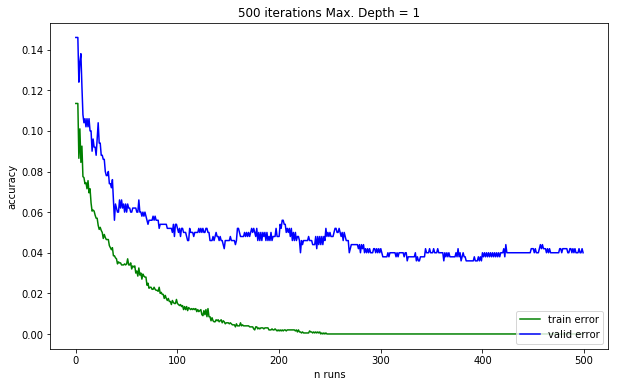

In [140]:
x = np.linspace(1 , 5 , len(valid_stage_score1))
fig = plt.figure(figsize=(10, 6))
train = plt.plot(1-train_stage_score1 , 'g' , label = 'train error')
test = plt.plot(1-valid_stage_score1 , 'b' , label = 'valid error')
plt.xlabel('n runs')
plt.ylabel('accuracy')
plt.legend(loc = 'lower right')
plt.title('500 iterations Max. Depth = 1')
plt.show()

In [141]:
train_stage_score2 = booster2.staged_score(data.X_train, data.y_train)
valid_stage_score2 = booster2.staged_score(data.X_valid, data.y_valid)

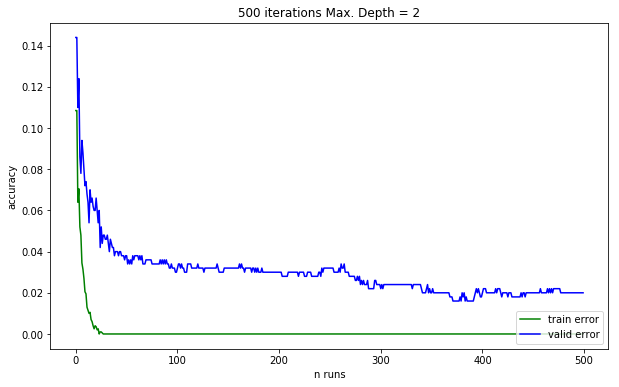

In [142]:
x = np.linspace(1 , 5 , len(valid_stage_score2))
fig = plt.figure(figsize=(10, 6))
train = plt.plot(1-train_stage_score2 , 'g' , label = 'train error')
test = plt.plot(1-valid_stage_score2 , 'b' , label = 'valid error')
plt.xlabel('n runs')
plt.ylabel('accuracy')
plt.legend(loc = 'lower right')
plt.title('500 iterations Max. Depth = 2')
plt.show()

In [143]:
train_stage_score3 = booster3.staged_score(data.X_train, data.y_train)
valid_stage_score3 = booster3.staged_score(data.X_valid, data.y_valid)

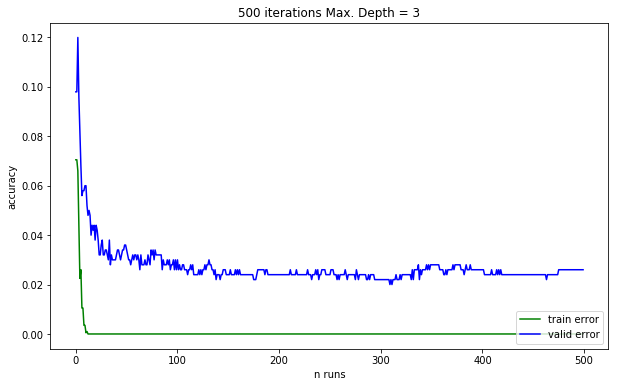

In [144]:
x = np.linspace(1 , 5 , len(valid_stage_score3))
fig = plt.figure(figsize=(10, 6))
train = plt.plot(1-train_stage_score3 , 'g' , label = 'train error')
test = plt.plot(1-valid_stage_score3 , 'b' , label = 'valid error')
plt.xlabel('n runs')
plt.ylabel('accuracy')
plt.legend(loc = 'lower right')
plt.title('500 iterations Max. Depth = 3')
plt.show()

The graphs above show that as the depth increases (complexity increases) the training error reaches 0 earlier. When the max depth is equal to 1, the training error reaches 0 at iteration 230 to 250. Whereas when the maximum depth is 2 or 3, the amount of iterations needed to reach zero training error range between 20 and 35 iterations.

On the other hand, the validation error decreases faster as the maximum depth increases. There is a constant decrease when the maxmimum depth is 1 or 2. When max depth is 1, the validation error does not decrease lower than 0.04. It reaches 0.04 after 330 iterations. When the maximum depth is 2, the validation error does not decrease lower than 0.02. It reaches 0.02 after 380 iterations However, when the maximum depth is 3, it reaches 0.02 very early (around 220 iterations) and oscilates between 0.03 and 0.02. 

Additionally, when the maximum depth is 3, and after 400 iterations, the validation error starts to increase. This is a sign of overfitting which indicates increasing the complexity will eventually lead to overfitting with earlier iterations.

In conclusion, from the plots above, it seems the most suitable complexity is when the maximum depth is equal to 2 because it resulted in a constant decrease in the validation error and an early 0 training error.

### [15 points] Problem 4: AdaBoost as a Margin-Maximizing Model 
***

Despite the fact that we're making our model more complex with the addition of each weak learner, AdaBoost does not typically overfit the training data. The reason for this is that the model becomes more _confident_ with each boosting iteration. This _confidence_ can be interpreted mathematically as a margin. Recall that after $K$ iterations the algorithm terminates with the classifier 

$$
H({\bf x}) = \textrm{sign}\left[\displaystyle\sum_{k=1}^K\alpha_k h_k({\bf x}) \right]
$$

Similarly, we can define the intermediate classifier $H_\ell$ by 

$$
H_\ell({\bf x}) = \textrm{sign}\left[\displaystyle\sum_{k=1}^\ell\alpha_k h_k({\bf x}) \right]
$$

where $\ell \leq K$. Note that in either case the model returns predictions of the form $y \in \{-1, 1\}$ which does not give us any indication of the model's confidence in a prediction. Define the normalized coefficients $\hat{\alpha}_k$ as follows: 

$$
\hat{\alpha}_k = \dfrac{\alpha_k}{\sum_{t=1}^K \alpha_k}
$$

Define the margin of a training example ${\bf x}$ after $\ell$ iterations as the sum of the normalized coefficients of weak learners that vote correctly minus the sum of the normalized coefficients of the weak learners that vote incorrectly: 

$$
\textrm{margin}_\ell ({\bf x}) = \sum_{k=1:~h_k({\bf x}) = y}^\ell \hat{\alpha}_k - \sum_{k=1:~h_k({\bf x}) \neq y}^\ell \hat{\alpha}_k 
$$

**Part A**: Briefly explain mathematically how $\textrm{margin}_\ell({\bf x})$ can be interpreted as a margin.  **Hint**: You'll want to think back on what we meant by a _margin_ in our discussion of Support Vector Machines. 

Thinking back about SVMs, we learned how the "distance" between a point and the boundary line and how it tells communicates with us regarding the accuracy of classifying that particular training example. The further away a point is from the boundary line in the correct area, the more confident the model is in classifying it. Hence, the $\textrm{margin}_\ell({\bf x})$ communicates the accuracy and how good the learners are in classifying training examples. As a result, there are three outcomes for $\textrm{margin}_\ell({\bf x})$ which include:

1- $\textrm{margin}_\ell({\bf x})$ > 0 (greater than 0 significantly)

2- $\textrm{margin}_\ell({\bf x})$ = 0 (equal to 0 or approximately 0)

3- $\textrm{margin}_\ell({\bf x})$ < 0 (less than 0 significantly)

The first case indicates that training example x is classified with high confidence, the second case indicates x was classifeid with low confidence, and the last case indicates that the training example is classified incorrectly.

**Part B**: Complete the `staged_margin` method in the `AdaBoost` class above so that it computes the margin for a single training example ${\bf x}$ after each boosting iteration. 

In [145]:
booster = AdaBoost(n_learners=50, base=DecisionTreeClassifier(max_depth=3), random_state=1234)
booster.fit(data.X_train, data.y_train)
margins = booster.staged_margin(data.X_train[0], data.y_train[0])
print(margins)

[ 0.03425519  0.05623415  0.0738825   0.05282883  0.07869531  0.10012655
  0.12359159  0.14717028  0.12852011  0.14633948  0.17155313  0.19446085
  0.21421844  0.23242962  0.21849924  0.24403117  0.26241222  0.27860137
  0.2637819   0.28379915  0.30540662  0.32016861  0.33956739  0.31620672
  0.32956406  0.31179484  0.32844672  0.35095805  0.33489048  0.35384905
  0.37481842  0.39360637  0.41661326  0.43420378  0.41385132  0.39423103
  0.41894508  0.43796776  0.46200595  0.48152912  0.46293246  0.47830359
  0.50033521  0.52116315  0.54212957  0.56278607  0.54389046  0.55894556
  0.57458659  0.59376766]


**Part C**: Find four **training** examples from the MNIST that meet the following criteria: 

- one $3$ that AdaBoost can classify easily  
- one $8$ that AdaBoost can classify easily  
- one $3$ that AdaBoost has difficulty with 
- one $8$ that AdaBoost has difficulty with 

Use the `view_digit` function given below to display the four examples that you found. 

**Advice**: Since AdaBoost will likely classify **all** training examples correctly given enough boosting iterations, you might try fitting an AdaBoost classifier with just a handful of boosting iterations and use it to identify examples of each desired type. 

true label: -1


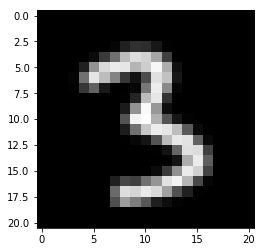

In [146]:
def view_digit(example, label=None):
    if label: print("true label: {:d}".format(label))
    plt.imshow(example.reshape(21,21), cmap='gray');
    
view_digit(data.X_train[0,:], data.y_train[0])

#Note: label is equal +1 if 8, label is equal to -1 if 3

In [147]:
threes = []
eights = []

for i in range(len(data.X_train)):
    if data.y_train[i] == 1:
        eights.append((booster.staged_margin(data.X_train[i], data.y_train[i])[-1], i))
    else:
        threes.append((booster.staged_margin(data.X_train[i], data.y_train[i])[-1], i))
        
threes = sorted(threes, key=lambda x: x[0])
eights = sorted(eights, key=lambda x: x[0])

1- Easy Three

(0.84126577041550332, 953)
true label: -1


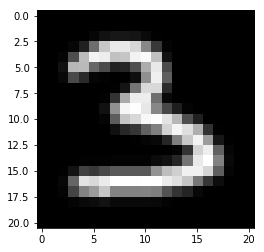

In [148]:
print(threes[-1])
index1 = threes[-1][1]
view_digit(data.X_train[index1,:], data.y_train[index1])

2- Easy Eight

(0.90366691172898239, 1230)
true label: 1


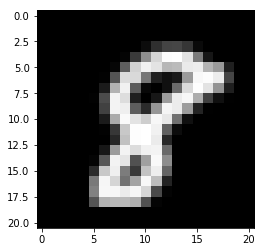

In [149]:
print(eights[-1])
index2 = eights[-1][1]
view_digit(data.X_train[index2,:], data.y_train[index2])

3- Difficult Three

(0.25636745351747248, 1633)
true label: -1


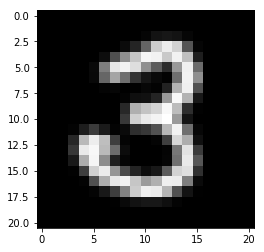

In [150]:
print(threes[0])
index3 = threes[0][1]
view_digit(data.X_train[index3,:], data.y_train[index3])

4- Difficult Eight

(0.24765017121686811, 65)
true label: 1


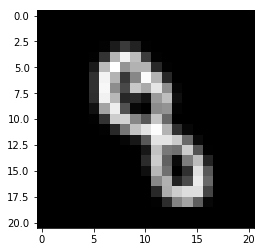

In [151]:
print(eights[0])
index4 = eights[0][1]
view_digit(data.X_train[index4,:], data.y_train[index4])

**Part D**: Using an AdaBoost classifier with at least $K=200$ depth-1 decision trees as the weak learners, plot the staged margin for each of the four examples that you found in **Part C** on the same set of axes. (Be sure to include a legend so we can tell which staged margin corresponds to which example).  Explain your results in terms of the margin of the classifier on each training examples.  More broadly, how the margin-maximizing property might allow AdaBoost to continue improving generalization even after the error on the training set reaches zero.  


In [152]:
booster = AdaBoost(n_learners=200, base=DecisionTreeClassifier(max_depth=1), random_state=1234)
booster.fit(data.X_train, data.y_train)

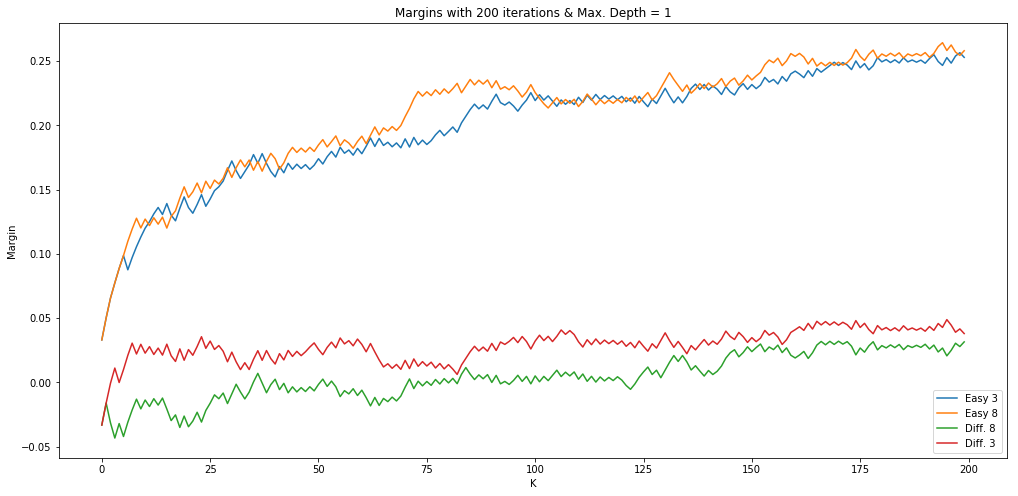

In [153]:
Ethree = []
Dthree = []
Eeight = []
Deight = []

for i in range(len(data.X_train)):
    if i == index1:
        Ethree = booster.staged_margin(data.X_train[i], data.y_train[i])
    elif i ==index2:
        Eeight = booster.staged_margin(data.X_train[i], data.y_train[i])
    elif i == index3:
        Dthree = booster.staged_margin(data.X_train[i], data.y_train[i])
    elif i == index4:
        Deight = booster.staged_margin(data.X_train[i], data.y_train[i])

x = np.linspace(1 , 5 , len(Ethree))
fig = plt.figure(figsize=(17, 8))
plt.plot(Ethree , label = 'Easy 3')
plt.plot(Eeight , label = 'Easy 8')
plt.plot(Deight , label = 'Diff. 8')
plt.plot(Dthree , label = 'Diff. 3')
plt.xlabel('K')
plt.ylabel('Margin')
plt.legend(loc = 'lower right')
plt.title('Margins with 200 iterations & Max. Depth = 1')
plt.show()

In [154]:
print("margins at the last iteration")
print(" ")
for elements in threes:
    if index1 == elements[:][1]:
        margin_strong3 = Ethree[-1]
    elif index3 == elements[:][1]:
        margin_weak3 = Dthree[-1]

print("Easy 3: " + str(margin_strong3))
print("Difficult 3: " + str(margin_weak3))
        
for elements in eights:
    if index2 == elements[:][1]:
        margin_strong8 = Eeight[-1]
    elif index4 == elements[:][1]:
        margin_weak8 = Deight[-1]
        
print("Easy 8: " + str(margin_strong8))
print("Difficult 8: " + str(margin_weak8))

margins at the last iteration
 
Easy 3: 0.252877509984
Difficult 3: 0.0380396449241
Easy 8: 0.258019959464
Difficult 8: 0.0315663229332


As seen in the plot, the margins for the difficult training examples from part C do not vary much. They increase gradually, but very slowly. This could be due to the property of the image itself which makes them hard to classify. In fact, this can be verified in the images plotted above. The difficult 3 looks very similar to an 8, it is a few pixels away from an 8. Whereas the difficult 8 is very different from the easy 8. It is much thinner, and has less black pixels in the middle. 

On the other hand, the easy images are relatively easier to classify correctly, which resulted in the high margins and gradual increase as the number of iterations (n learners) increase.

To understand how margins can improve even when the training error reaches 0, I will use the plot below.

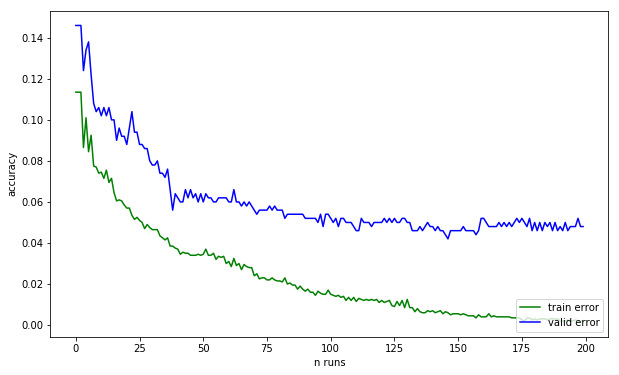

In [155]:
train_stage_score = booster.staged_score(data.X_train, data.y_train)
valid_stage_score = booster.staged_score(data.X_valid, data.y_valid)

x = np.linspace(1 , 5 , len(valid_stage_score))
fig = plt.figure(figsize=(10, 6))
train = plt.plot(1-train_stage_score , 'g' , label = 'train error')
test = plt.plot(1-valid_stage_score , 'b' , label = 'valid error')
plt.xlabel('n runs')
plt.ylabel('accuracy')
plt.legend(loc = 'lower right')
plt.show()

The two plots demonstrate how margins can keep improving even if the training error reaches 0. As a result, the model can grow confident in it's classifying ability for each training example. While the margins grow insignificantly, it tells us that with enough iterations, and perhaps complexity, the model can become very confident in classifying difficult images, let alone the easier ones. To verify this, I will create another classifier with n learners of 500 and complexity of two.

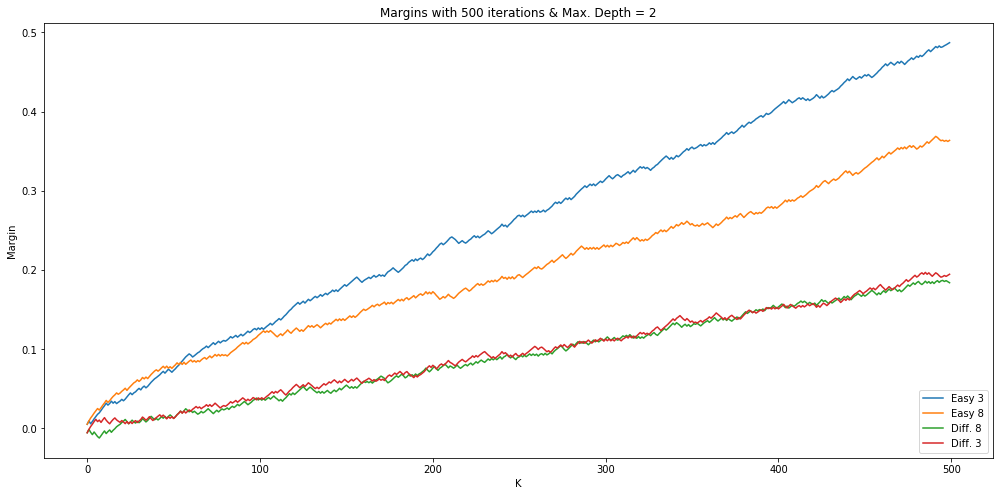

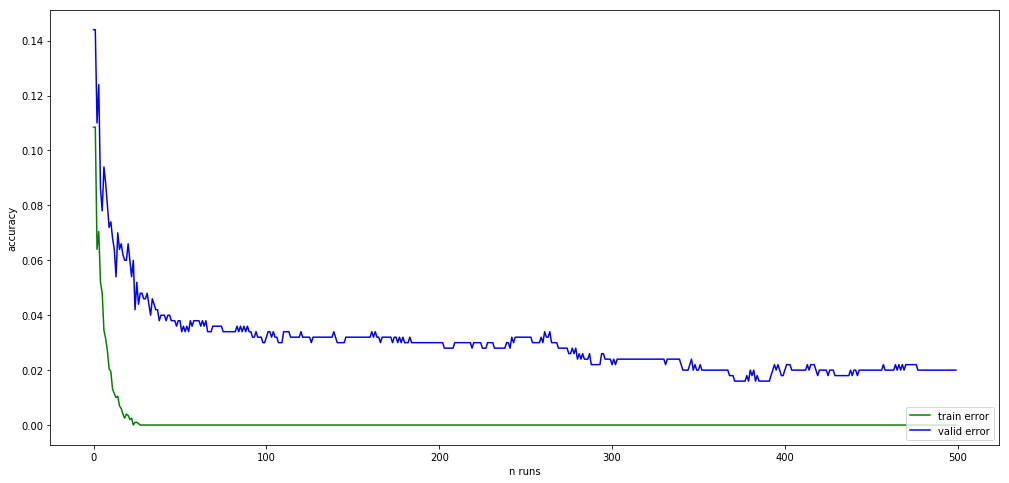

In [156]:
booster = AdaBoost(n_learners=500, base=DecisionTreeClassifier(max_depth=2), random_state=1234)
booster.fit(data.X_train, data.y_train)

Ethree = []
Dthree = []
Eeight = []
Deight = []

for i in range(len(data.X_train)):
    if i == index1:
        Ethree = booster.staged_margin(data.X_train[i], data.y_train[i])
    elif i ==index2:
        Eeight = booster.staged_margin(data.X_train[i], data.y_train[i])
    elif i == index3:
        Dthree = booster.staged_margin(data.X_train[i], data.y_train[i])
    elif i == index4:
        Deight = booster.staged_margin(data.X_train[i], data.y_train[i])

x = np.linspace(1 , 5 , len(Ethree))
fig = plt.figure(figsize=(17, 8))
plt.plot(Ethree , label = 'Easy 3')
plt.plot(Eeight , label = 'Easy 8')
plt.plot(Deight , label = 'Diff. 8')
plt.plot(Dthree , label = 'Diff. 3')
plt.xlabel('K')
plt.ylabel('Margin')
plt.legend(loc = 'lower right')
plt.title('Margins with 500 iterations & Max. Depth = 2')
plt.show()

train_stage_score = booster.staged_score(data.X_train, data.y_train)
valid_stage_score = booster.staged_score(data.X_valid, data.y_valid)

x = np.linspace(1 , 5 , len(valid_stage_score))
fig = plt.figure(figsize=(17, 8))
train = plt.plot(1-train_stage_score , 'g' , label = 'train error')
test = plt.plot(1-valid_stage_score , 'b' , label = 'valid error')
plt.xlabel('n runs')
plt.ylabel('accuracy')
plt.legend(loc = 'lower right')
plt.show()

As expected, with more iterations and a higher complexity, the margins for each image from part C are significantly higher even when the training error reaches 0 very early. This verifies our idea that the model can classify difficult images with a higher confidence given enough iterations and high enough complexity which is shown through the higher margins.